In [1]:
'''
Jupyter Notebook by Matthew Loukine
'''
'''
This first block of code is used for import statements, data loading and doing some data pre processing
Such as Motion Correction.
'''
# The following file is being used to test the Pipeline
''' Import statements for all the files involved'''
from main import *
from utils import *
from wfield_utils import *
from registration import *
from hemocorrection import *
from denoising import *
from debug_visualize import *
from data_loading_functions import *
from data_preprocessor import *

# Some extra imports we need
from tqdm import tqdm
import pickle
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import timedelta
import scipy.signal
import cv2
import os

# The folllowing code is from main(). 
# params are global variables used to modify the code
params = {
    'path_to_session_data':       r"C:\Users\evilm\Downloads\12-08-2024",
    'pipe_num':           0,              # select desired pipeline number
    'get_raw_brightness': False,
    'get_DeltaF':         False,
    'get_zScore':         False
          }
STIM_COMPUTER = True # There is STIM COMPUTER Data
BLUE_AND_VIOLET_EXISTS = True # Both types of frames were recorded
LED = True # When using LED data set this to True, set it to False otherwise
OLFAC = False # When using OLFAC data set this to True, set it to False otherwise
CAMERA_HZ = 40 # Acquistion Rate
if BLUE_AND_VIOLET_EXISTS :
    CHANEL_NUM = 2 # Number of channels, violet and blue = 2
else:
    CHANEL_NUM = 1

# This is inside def main()
# For purposes of testing to visualise the data we will do analysis here.
session_file_paths = get_file_paths(params['path_to_session_data'])
# create an obj for each recording within the session
recording = rawDataPreprocessor(params['path_to_session_data'], blue_and_violet_exists=BLUE_AND_VIOLET_EXISTS,stim_computer=STIM_COMPUTER)
print(f'{datetime.datetime.now().time()}: Done loading session data into object')

# Currently Motion Correction Only
print(f'{datetime.datetime.now().time()}: Starting Motion Correction')
_, _, recording.all_frames = motion_correct(dat=recording.all_frames, out=None, mode='ecc', apply_shifts=True)
print(f'{datetime.datetime.now().time()}: Done Motion Correction')

# Denoising and Compression Step
print(f'{datetime.datetime.now().time()}: Starting Blue Frame Denoising and Compression')
recording.all_frames[:,0,...], _ = denoise_svd(recording.all_frames[:,0,...],rank=200) # Blue Frames are First
print(f'{datetime.datetime.now().time()}: Done Blue Frame Denoising and Compression')
if BLUE_AND_VIOLET_EXISTS:
    print(f'{datetime.datetime.now().time()}: Starting Blue Frame Denoising and Compression')
    recording.all_frames[:,1,...],  _ = denoise_svd(recording.all_frames[:,1,...] ,rank=200) # Violet Frames are Second
    print(f'{datetime.datetime.now().time()}: Done Blue Frame Denoising and Compression')

# HemoCorrection Step
if BLUE_AND_VIOLET_EXISTS:
    print(f'{datetime.datetime.now().time()}: Starting HemoCorrection')
    recording.all_frames[:,0,...] = hemocorrection(blue_frames=recording.all_frames[:,0,...], violet_frames=recording.all_frames[:,1,...])
    print(f'{datetime.datetime.now().time()}: Done HemoCorrection')

# Segementation Step

# Loading all the other files.
blue_frames = recording.all_frames[:,0,...]
if BLUE_AND_VIOLET_EXISTS:
    violet_frames = recording.all_frames[:,1,...]
analog_data = load_dat_analog(recording.path_to_analog)
frame_times = load_mat_frameTimes(recording.path_to_frameTimes)
blue_ftimes = frame_times['frameTimes']
if BLUE_AND_VIOLET_EXISTS:
    blue_ftimes = frame_times['frameTimes'][::2] # blue frame occurs first
    violet_ftimes = frame_times['frameTimes'][1::2]
    violet_frames = recording.all_frames[:,1,...]
stim_matfile = recording.path_to_stimcomputer
stim_configs = pickle.loads(scipy.io.loadmat(stim_matfile)['configs'].tostring())
stim_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(stim_matfile)['experiment_start_timestamp'].tostring())
# Skipping software environement
stim_stim_frame_info = pickle.loads(scipy.io.loadmat(stim_matfile)['stimulus_frame_info'].tostring())
stim_user_data = pickle.loads(scipy.io.loadmat(stim_matfile)['user_data'].tostring())
stim_sync = scipy.io.loadmat(stim_matfile)['sync']

11:57:17.969219: Done loading session data into object
11:57:17.969723: Starting Motion Correction


Motion correction: 100%|██████████| 5/5 [01:38<00:00, 19.67s/it]

11:59:00.118316: Done Motion Correction
11:59:00.119325: Starting Blue Frame Denoising and Compression



Denoising: 100%|██████████| 2575/2575 [07:38<00:00,  5.61it/s]
c:\Users\evilm\OneDrive\Desktop\Lab Work\Trenholm Lab\wfield_pipeline\denoising.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(im_array),np.array(SVD_stack))


12:06:41.343770: Done Blue Frame Denoising and Compression
12:06:41.345765: Starting Blue Frame Denoising and Compression


Denoising: 100%|██████████| 2575/2575 [07:50<00:00,  5.47it/s]


12:14:34.549392: Done Blue Frame Denoising and Compression
12:14:34.598437: Starting HemoCorrection


100%|██████████| 2575/2575 [00:24<00:00, 106.12it/s]


12:16:44.989962: Done HemoCorrection


C:\Users\evilm\AppData\Local\Temp\ipykernel_1076\3805658838.py:91: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_configs = pickle.loads(scipy.io.loadmat(stim_matfile)['configs'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_1076\3805658838.py:92: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(stim_matfile)['experiment_start_timestamp'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_1076\3805658838.py:94: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_stim_frame_info = pickle.loads(scipy.io.loadmat(stim_matfile)['stimulus_frame_info'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_1076\3805658838.py:95: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_user_data = pickle.loads(scipy.io.loadmat(stim_matfile)['user_data'].tostring())


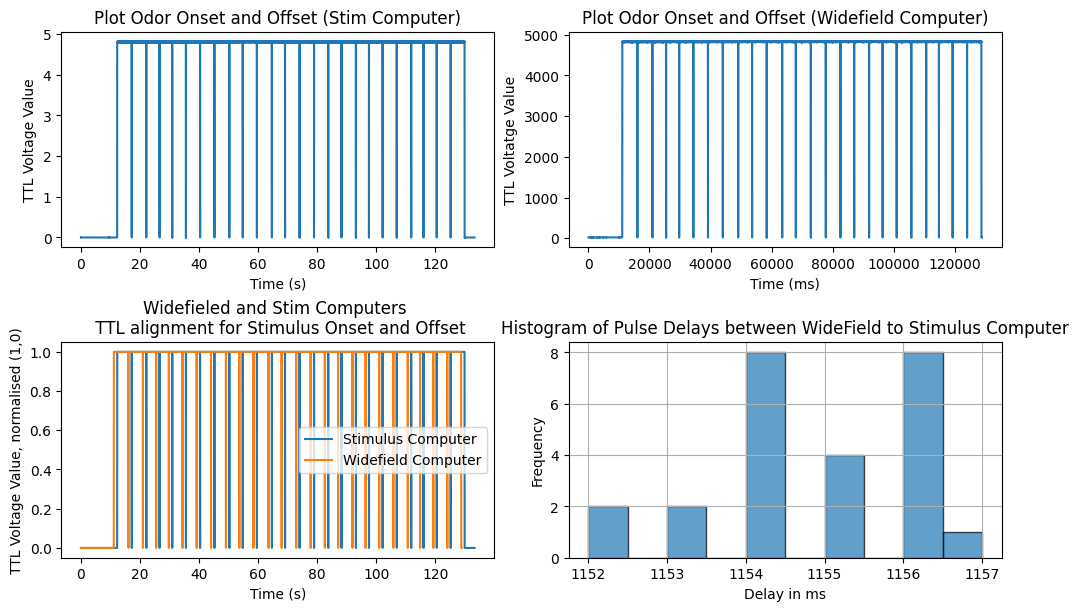

In [2]:
'''
This compares stimulus computer and widefield computer TTL pulses.
This block of code is used for sanity checks!
'''
%matplotlib inline
# This line increases the limit of how many points can be plotted on matplotlib
mpl.rcParams['agg.path.chunksize'] = 100000

def compress_array(arr, factor):
    """
    list<int>, int -> list<int>

    Compress a binary array by a given factor.
    """
    compressed_length = len(arr) // factor
    compressed_array = np.zeros(compressed_length, dtype=int)
    
    for i in range(compressed_length):
        start_idx = i * factor
        end_idx = start_idx + factor
        # Check if there is at least one `1` in the chunk
        if np.any(arr[start_idx:end_idx]):
            compressed_array[i] = 1
    
    return compressed_array.tolist()

# Converting the time into seconds, by deafult it is nano, since sampling rate is 10kHz
x_values = np.arange(1, stim_sync.shape[0] + 1) / 10000

# Making figure with axes
fig,axes = plt.subplots(ncols=2,nrows=2, figsize=(10,6),layout='constrained')

# Plot, remembering stim_sync[1] is the onset of smell. 
# NOTICE the x-axis, we will correct for this further along. 
axes[0,0].plot(x_values, stim_sync[:, 1])
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('TTL Voltage Value')
axes[0,0].set_title('Plot Odor Onset and Offset (Stim Computer)')

wf_analog_data = np.array(analog_data[0])
axes[0,1].plot(wf_analog_data[4])
axes[0,1].set_xlabel('Time (ms)')
axes[0,1].set_ylabel('TTL Voltatge Value')
axes[0,1].set_title('Plot Odor Onset and Offset (Widefield Computer)')

# Normalising pulses, to being between 1 and 0 and turning into binary arrays 
normalised_stim_signal = (stim_sync[:,1]-np.min(stim_sync[:,1]))/(np.max(stim_sync[:,1])-np.min(stim_sync[:,1]))
normalised_stim_signal = np.where(np.array(normalised_stim_signal) > 0.5, 1, 0)
# Stimulus Computer records data 10* the speed of WideField Computer, for comparision and so that we can do alignment later,
# We need to compress the Stimulus Computer Signal by a factor of 10  
normalised_stim_signal = np.array(compress_array(normalised_stim_signal,10))  
# Normalising pulses, to being between 1 and 0 and turning into binary arrays
normalised_wf_signal = (wf_analog_data[4]-np.min(wf_analog_data[4]))/(np.max(wf_analog_data[4])-np.min(wf_analog_data[4])) 
normalised_wf_signal = np.where(np.array(normalised_wf_signal) > 0.5, 1, 0)

# Making x-values for graphing
x_values = np.arange(1, normalised_stim_signal.shape[0] + 1) /  1000 # This converts it into seconds
x_values_two = np.arange(1, wf_analog_data.shape[1] + 1) / 1000 # This convers it into seconds the /1000

axes[1,0].plot(x_values,normalised_stim_signal, label="Stimulus Computer")
axes[1,0].plot(x_values_two,normalised_wf_signal, label="Widefield Computer")
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('TTL Voltage Value, normalised (1,0)')
axes[1,0].set_title('Widefieled and Stim Computers \n TTL alignment for Stimulus Onset and Offset')
axes[1,0].legend()

def find_onset_indices(arr):
    """Find the indices of the first occurrence of `1` in each contiguous block of `1`s in the array."""
    onset_indices = []
    in_pulse = False
    for i, value in enumerate(arr):
        if value > 0.9:
            if not in_pulse:
                onset_indices.append(i)
                in_pulse = True
        else:
            in_pulse = False
    return onset_indices

def calculate_delays(array1, array2):
    """Calculate the delays between the onsets of pulses in two binary arrays."""
    onset_indices1 = find_onset_indices(array1)
    onset_indices2 = find_onset_indices(array2)
    # Ensure both arrays have at least one onset
    if not onset_indices1 or not onset_indices2:
        raise ValueError("One or both arrays do not contain any pulses.")
    delays = []
    len1 = len(onset_indices1)
    len2 = len(onset_indices2)
    max_len = min(len1, len2)
    for i in range(max_len):
        delay = onset_indices1[i] - onset_indices2[i]
        delays.append(delay)
    return delays

delays = calculate_delays(normalised_stim_signal,normalised_wf_signal)
bins = 10
# Compute histogram
counts, edges = np.histogram(delays, bins=bins)
# Use plt.bar to plot histogram with no space between bars
bar_width = edges[1] - edges[0]
axes[1,1].bar(edges[:-1], counts, width=bar_width, edgecolor='black', align='edge', alpha=0.7)
axes[1,1].set_title('Histogram of Pulse Delays between WideField to Stimulus Computer')
axes[1,1].set_xlabel('Delay in ms')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True)

plt.show()

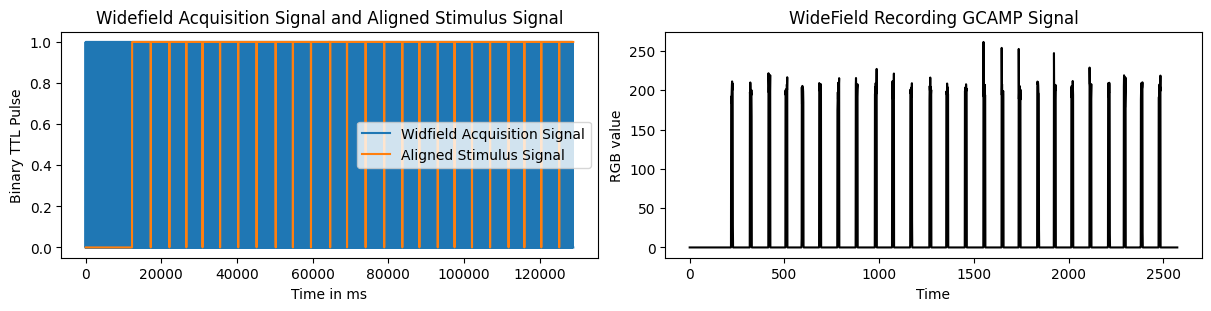

Number of Stim Blocks is : 25
Time in ms that TTL Widefield Acquisition was on for 128900ms
Time in ms that Frames were capture for 128750.0ms


True Alignment: 100%|██████████| 25/25 [00:00<00:00, 1112.74it/s]


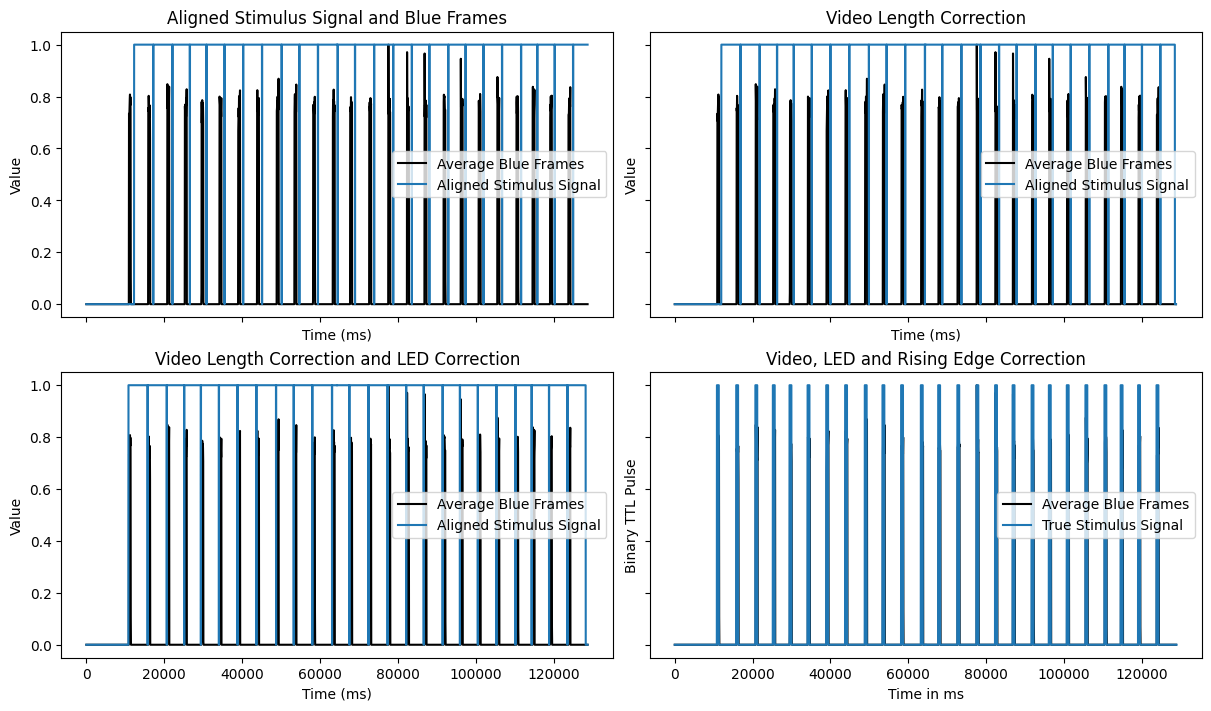

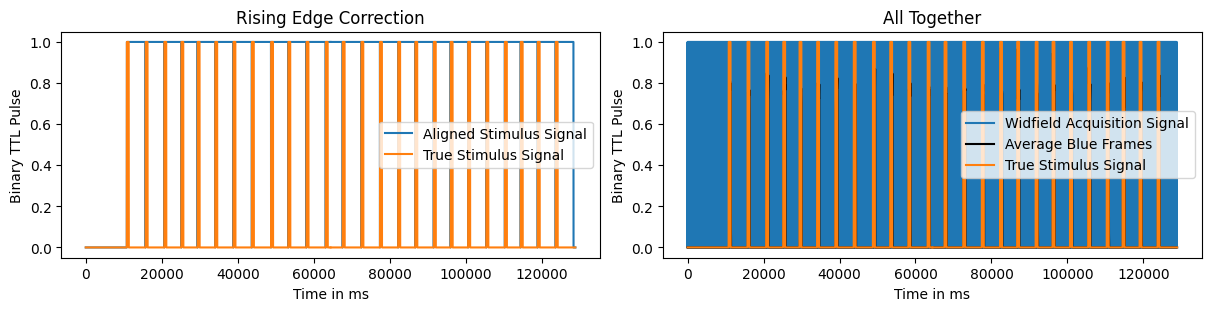

In [46]:
''' 
The following block of code, shows the acquisition and stimulus signal overlapped. 
'''
%matplotlib inline
#The delay is minimal, so we actually can just use the Stimulus Computer TTL, as our WideField one. All we need to do is change the shape.
# If we don't have the Stimulus Computer Data then we use the normalise_wf_signal as out aligned_stim_signal
aligned_stim_signal = normalised_stim_signal[:normalised_wf_signal.shape[0]]

# Now we can line up our acquisition signal and our stim signal
wf_acquisition_signal = np.array(wf_analog_data[1])
# Normalising and turining into binary 
wf_acquisition_signal = (wf_acquisition_signal-np.min(wf_acquisition_signal))/(np.max(wf_acquisition_signal)-np.min(wf_acquisition_signal))
wf_acquisition_signal = np.where(np.array(wf_acquisition_signal) > 0.5 ,1, 0 )

fig,axes = plt.subplots(ncols=2,nrows=1, figsize=(12,3),layout='constrained')
axes[0].plot(wf_acquisition_signal, label="Widfield Acquisition Signal")
axes[0].plot(aligned_stim_signal, label='Aligned Stimulus Signal')
axes[0].set_ylabel("Binary TTL Pulse")
axes[0].set_xlabel('Time in ms')
axes[0].set_title('Widefield Acquisition Signal and Aligned Stimulus Signal')
axes[0].legend()

# NOTE - Zooming into the graph, and into one pulse, the acquisition become much clearer.

'''
The following before we do any other analysis just plots the signal (the average of the image)
'''
# Calculating a signal over the images
signal_mean = np.mean(blue_frames,axis=(1,2))
axes[1].plot(signal_mean, color = 'black')
axes[1].set_title('WideField Recording GCAMP Signal')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('RGB value')
plt.show()

# Also calculating how many peaks there are in this signal
# Ideally this should equal the amount of stimulus repeats 
# May need to modify the distance metric. 
peaks, _ = scipy.signal.find_peaks(signal_mean,distance=10)
print('Number of Stim Blocks is : ' + str(len(peaks)))

# Here we notice that the time in aquisition is different.
# We want to figure out this difference, before we do anything
print('Time in ms that TTL Widefield Acquisition was on for ' + str(len(aligned_stim_signal)) + 'ms')
print('Time in ms that Frames were capture for ' + str((blue_frames.shape[0]/40) * 1000 * 2) + 'ms')

num_frames = blue_frames.shape[0]
num_stim_points = len(aligned_stim_signal)

# Our x-axis
time_stim = np.linspace(0,num_frames / CAMERA_HZ * 1000 * CHANEL_NUM, num_stim_points)
time_blue_frames = np.linspace(0,num_frames / CAMERA_HZ * 1000 * CHANEL_NUM,num_frames)

# Normalised the signal mean
signal_mean = (signal_mean-np.min(signal_mean))/(np.max(signal_mean)-np.min(signal_mean))
fig,axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7),layout='constrained',sharex=True, sharey=True)

axes[0,0].plot(time_blue_frames,signal_mean, label='Average Blue Frames', color='black')
axes[0,0].plot(time_stim, aligned_stim_signal, label='Aligned Stimulus Signal')
# Plot average blue_frames
axes[0,0].set_xlabel('Time (ms)')
axes[0,0].set_ylabel('Value')
axes[0,0].set_title('Aligned Stimulus Signal and Blue Frames')
axes[0,0].legend()

# NOTE and TODO
# Here we make the assumption that the extra time, is at the begining. And now both signals we want
# Stim and WF acquistion to account for this difference
diff = int(num_stim_points - (num_frames/CAMERA_HZ * 1000 * CHANEL_NUM)) * CHANEL_NUM
aligned_stim_signal = aligned_stim_signal[diff:]
aligned_stim_signal = np.concatenate((aligned_stim_signal, np.zeros(diff)))


num_stim_points = len(aligned_stim_signal)
time_stim = np.linspace(0,num_frames / CAMERA_HZ * 1000 * CHANEL_NUM, num_stim_points)

axes[0,1].plot(time_blue_frames,signal_mean, label='Average Blue Frames', color='black')
axes[0,1].plot(time_stim, aligned_stim_signal, label='Aligned Stimulus Signal')
# Plot average blue_frames
axes[0,1].set_xlabel('Time (ms)')
axes[0,1].set_ylabel('Value')
axes[0,1].set_title('Video Length Correction')
axes[0,1].legend()

# NOTE 08/13/2024
# The assumption that the Stimlus Computer activates the Stimulus is Incorrect for LED's. 
# The WideField computer activates the LED's Directly, so the difference we calculated in the delay
# between the Stimulus and WideField computer is not true. Instead we have to actually
# use the WideField Signal over the Stimulus Signal
if LED and not OLFAC:
    aligned_stim_signal = normalised_wf_signal[diff:]
    aligned_stim_signal = np.concatenate((aligned_stim_signal, np.zeros(diff)))
    axes[1,0].plot(time_blue_frames,signal_mean, label='Average Blue Frames', color='black')
    axes[1,0].plot(time_stim, aligned_stim_signal, label='Aligned Stimulus Signal')
    # Plot average blue_frames
    axes[1,0].set_xlabel('Time (ms)')
    axes[1,0].set_ylabel('Value')
    axes[1,0].set_title('Video Length Correction and LED Correction')
    axes[1,0].legend()
elif OLFAC and not LED:
    axes[1,0].set_title('LED Correction = N/A')
    axes[1,0].set_xlabel('Time (ms)')
    axes[1,0].set_ylabel('Value')
else:
    sys.exit('Data selection Inapropriate.')

# This function can be used for sanity checks, that are indeed the apropriate amount of stimuli
def count_blocks_of_ones(binary_array):
    arr = np.array(binary_array)
    transitions = np.diff(arr.astype(int))
    num_blocks = np.sum(transitions == 1) + (arr[0] == 1)
    return num_blocks
count_blocks_of_ones(aligned_stim_signal)

# The signal we see in the above graphs, can only be trusted on the RISING and not the Falling Edge,
# So we need to create our own 'Falling Edge', by manually adding the STIM_TIME
if LED and not OLFAC:
    STIM_TIME = stim_configs['experiment_config']['FLASH_TIME']
elif OLFAC and not LED:
    print(OLFAC)
    # TODO
else:
    sys.exit('Data selection Inapropriate.')

STIM_TIME = int(STIM_TIME * 1000) # Conversion into miliseconds
onset_indices = find_onset_indices(aligned_stim_signal)

def shrink_ones_groups(array_one, array_two, time):
    """
    Shrinks sequences of consecutive 1's in array_one to the specified 'time' length
    starting from indices specified in array_two.

    Parameters:
    - array_one (np.ndarray): The original array containing sequences of 1's and 0's.
    - array_two (list of int): The starting indices of sequences of 1's in array_one.
    - time (int): The desired length to which each sequence should be shrunk.

    Returns:
    - np.ndarray: The modified array with sequences adjusted to the 'time' length.
    """
    new_array = np.copy(array_one)

    for start_idx in tqdm(array_two, desc='True Alignment'):
        current_idx = start_idx
        # Find the end of the current sequence of 1's
        while current_idx < len(new_array) and new_array[current_idx] == 1:
            current_idx += 1
        end_idx = current_idx - 1
        # Determine the actual end index based on the 'time' variable
        actual_end = min(start_idx + time - 1, end_idx)
        # Set the required number of 1's
        new_array[start_idx:actual_end + 1] = 1
        # Set the remaining positions to 0
        if actual_end + 1 <= end_idx:
            new_array[actual_end + 1:end_idx + 1] = 0
    return new_array
true_aligned_stim_signal = shrink_ones_groups(aligned_stim_signal, onset_indices, STIM_TIME)

# Stimlus Average Response overlappyed with our True Stimulus Signal
axes[1,1].plot(time_blue_frames,signal_mean, label='Average Blue Frames', color='black')
axes[1,1].plot(true_aligned_stim_signal, label="True Stimulus Signal")
axes[1,1].set_ylabel("Binary TTL Pulse")
axes[1,1].set_xlabel('Time in ms')
axes[1,1].set_title('Video, LED and Rising Edge Correction')
axes[1,1].legend()
plt.show()

# Supplementary Graphs
fig,axes = plt.subplots(ncols=2,nrows=1, figsize=(12,3),layout='constrained')
axes[0].plot(aligned_stim_signal, label='Aligned Stimulus Signal')
axes[0].plot(true_aligned_stim_signal, label="True Stimulus Signal")
axes[0].set_ylabel("Binary TTL Pulse")
axes[0].set_xlabel('Time in ms')
axes[0].set_title('Rising Edge Correction')
axes[0].legend()


# All Together # NOTE zoom in needed
axes[1].plot(wf_acquisition_signal, label="Widfield Acquisition Signal")
axes[1].plot(time_blue_frames,signal_mean, label='Average Blue Frames', color='black')
axes[1].plot(true_aligned_stim_signal, label="True Stimulus Signal")
axes[1].set_ylabel("Binary TTL Pulse")
axes[1].set_xlabel('Time in ms')
axes[1].set_title('All Together')
axes[1].legend()
plt.show()


Matching Indices: 100%|██████████| 3768/3768 [00:00<00:00, 7955.23it/s] 

Number of Stim Blocks is: 25
Number of Frames TTL Pulses say there should be: 2580
Number of Frames Actually Collected - 2575



Seperating Frames: 100%|██████████| 2575/2575 [00:00<00:00, 206207.67it/s]


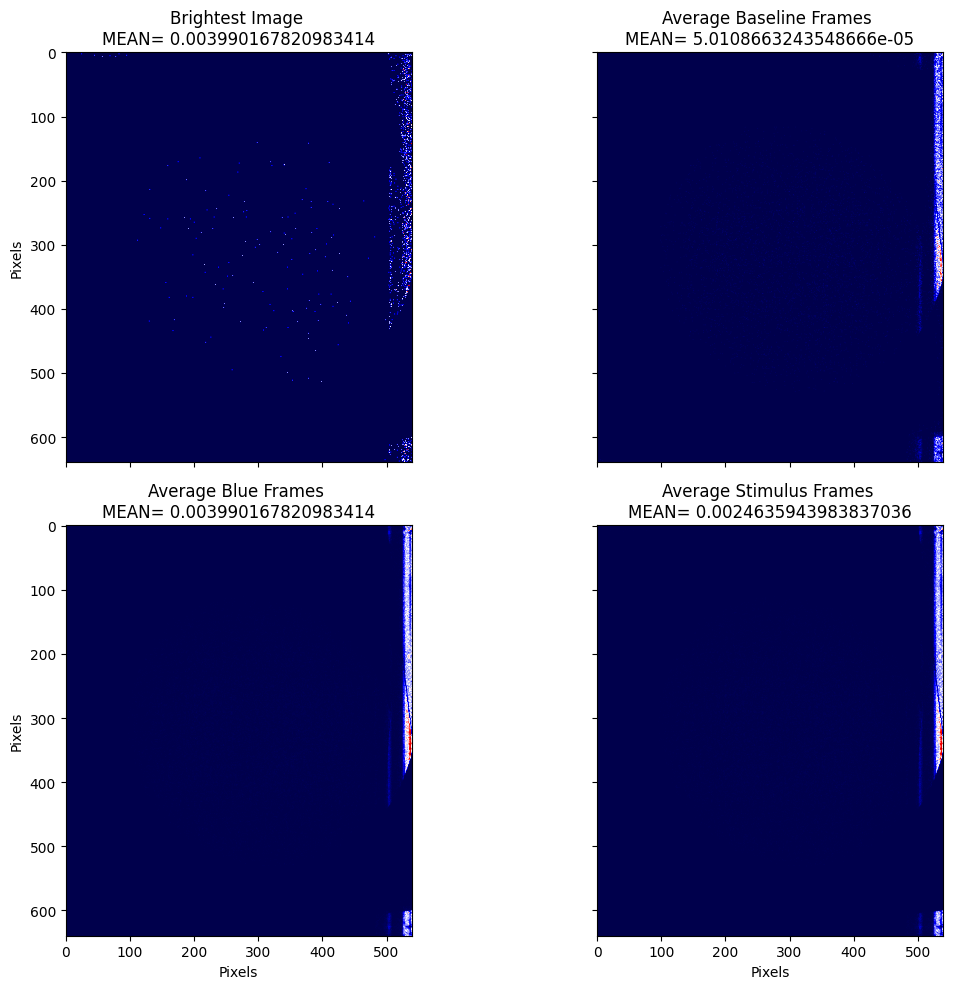

In [50]:
''' 
Seperating Out Baseline and Actual Frames
'''
%matplotlib inline
# Here we want to find at which indices, are there frames for the baseline
matching_indices = np.where((true_aligned_stim_signal == 1) & (wf_acquisition_signal == 1))[0]
# The following function finds at which index, are frames that are within the stimulus window.
def shrink_indices(array_one, array_two, matching_indices):
    """
    Shrinks Array_Two by collapsing blocks of 1's into a single 1, and returns the transformed matching indices.
    
    Parameters:
    - array_one (np.ndarray): The first array with sequences of 1's and 0's.
    - array_two (np.ndarray): The second array with blocks of 1's and 0's.
    - matching_indices (list of int): Indices where both Array_One and Array_Two initially match.
    
    Returns:
    - list of int: The new indices after shrinking Array_Two.
    """
    # Find the start and end of each block of 1's in Array_Two
    blocks = []
    in_block = False
    for i in range(len(array_two)):
        if array_two[i] == 1 and not in_block:
            # Start of a new block
            start_idx = i
            in_block = True
        elif array_two[i] == 0 and in_block:
            # End of a block
            end_idx = i - 1
            blocks.append((start_idx, end_idx))
            in_block = False
    # If the last block continues to the end of the array
    if in_block:
        end_idx = len(array_two) - 1
        blocks.append((start_idx, end_idx))
    # Map the matching indices to these blocks
    transformed_indices = []
    for idx in tqdm(matching_indices, desc='Matching Indices'):
        for block_num, (start, end) in enumerate(blocks):
            if start <= idx <= end:
                transformed_indices.append(block_num)
                break
    return transformed_indices

transformed_matching_indices = np.unique(shrink_indices(true_aligned_stim_signal, wf_acquisition_signal, matching_indices))

# This function is used for sanity checking.
def count_consecutive_blocks(array):
    """
    Counts the number of blocks of at least two consecutive numbers in the array.

    Parameters:
    - array (list of int): The input array of integers.

    Returns:
    - int: The number of consecutive blocks in the array.
    """
    if len(array) < 2:
        return 0
    block_count = 0
    current_block_length = 1
    for i in range(1, len(array)):
        # Check if the current element is consecutive with the previous one
        if array[i] == array[i - 1] + 1:
            current_block_length += 1
        else:
            # If the block is broken, check if it was valid (length >= 2)
            if current_block_length >= 2:
                block_count += 1
            current_block_length = 1  # Reset block length
    # After the loop, check the last block
    if current_block_length >= 2:
        block_count += 1
    return block_count
# Here we expect there to be the same amount of stimuli as blocks
print('Number of Stim Blocks is: ' + str(count_consecutive_blocks(transformed_matching_indices)))

# Before we seperate out baseline frames and signal frames we have to verify
# That the TTL pulses align with the amount of frames we collected 
print('Number of Frames TTL Pulses say there should be: ' + str(count_blocks_of_ones(wf_acquisition_signal)))
print('Number of Frames Actually Collected - ' + str(blue_frames.shape[0]))
# The OFF by Error needs to be fixed,
# TODO and NOTE Here we make an assumption that these lost frames that we do not have, were lost
# at the start of Acquisition. So we will subtract this difference from all our indexes above.
transformed_matching_indices = np.array(transformed_matching_indices) - (count_blocks_of_ones(wf_acquisition_signal) - blue_frames.shape[0])

max_bright_value = np.max(blue_frames,axis=(0,1,2))
normalised_blue_frames = []
for i, frame in enumerate(tqdm(blue_frames, desc='Normalising')):
    # Normalising each frame
    normalised_blue_frames.append((frame-0)/(max_bright_value-0))
np.array(normalised_blue_frames)

# Now we can seperate out the baseline frames and the signal frames
stimulus_frames = []
baseline_frames = []
for i, frame in enumerate(tqdm(normalised_blue_frames,desc='Seperating Frames')):
    if i in transformed_matching_indices:
        stimulus_frames.append(frame[:])
    else:
        baseline_frames.append(frame[:])
stimulus_frames = np.array(stimulus_frames)
baseline_frames = np.array(baseline_frames)

avg = []
for frame in normalised_blue_frames:
    avg.append(np.mean(frame))
brightest_img = np.argmax(avg)


fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 10))
# Plot Brightest Image
axs[0, 0].imshow(normalised_blue_frames[brightest_img], cmap='seismic')
axs[0, 0].set_title('Brightest Image \nMEAN= ' + str(np.mean(normalised_blue_frames[brightest_img])))
axs[0, 0].set_ylabel('Pixels')

# Plot Average Baseline Frames
axs[0, 1].imshow(np.mean(baseline_frames, axis=0), cmap='seismic')
axs[0, 1].set_title('Average Baseline Frames \nMEAN= ' + str(np.mean(baseline_frames,axis=(0,1,2))))

# Plot Average Blue Frames
axs[1, 0].imshow(np.mean(normalised_blue_frames, axis=0), cmap='seismic')
axs[1, 0].set_title('Average Blue Frames \nMEAN= ' + str(np.mean(normalised_blue_frames[brightest_img])))
axs[1, 0].set_ylabel('Pixels')
axs[1, 0].set_xlabel('Pixels')

# Plot Average Stimulus Frames
axs[1, 1].imshow(np.mean(stimulus_frames, axis=0), cmap='seismic')
axs[1, 1].set_title('Average Stimulus Frames \nMEAN= ' + str(np.mean(stimulus_frames,axis=(0,1,2))))
axs[1, 1].set_xlabel('Pixels')
plt.tight_layout()
plt.show()
#print(transformed_matching_indices)

Calculating:   0%|          | 0/2575 [00:00<?, ?it/s]C:\Users\evilm\AppData\Local\Temp\ipykernel_1076\2498196631.py:7: RuntimeWarning: divide by zero encountered in divide
  deltaFoverF_frames.append(((frame + 1) - baseline_avg) / baseline_avg)
Seperating Frames: 100%|██████████| 2575/2575 [00:00<00:00, 213631.08it/s]


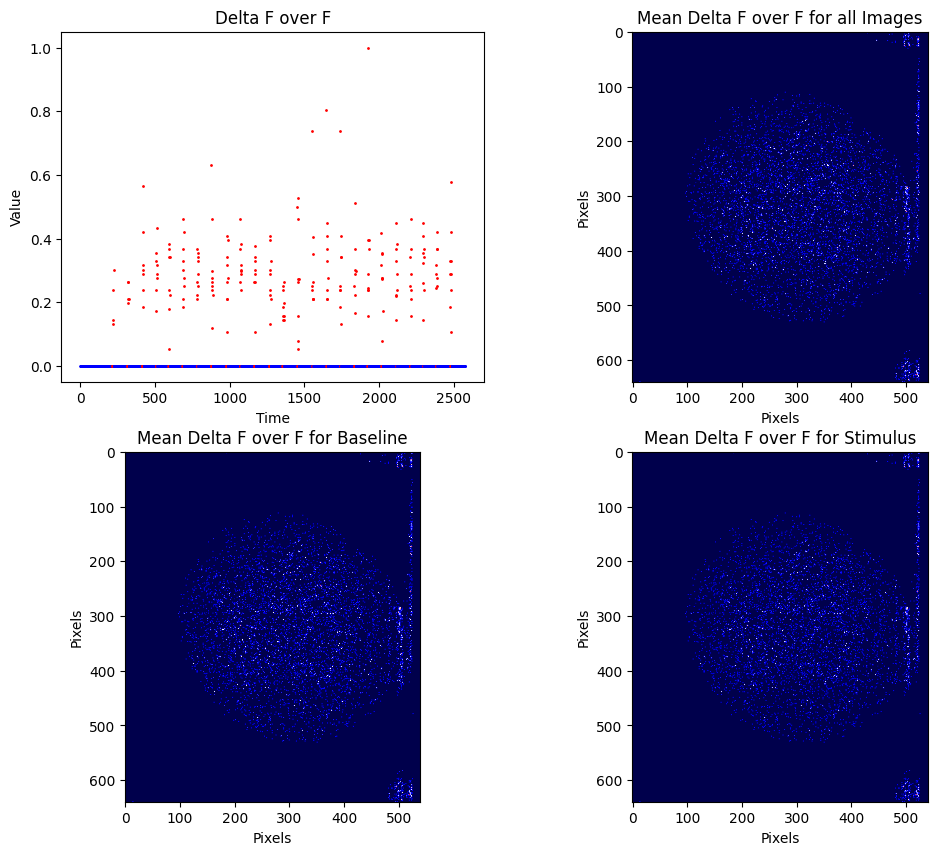

In [51]:
%matplotlib inline
# Generating F
baseline_avg = np.mean(baseline_frames,axis=0)
deltaFoverF_frames = []
for i, frame in enumerate(tqdm(normalised_blue_frames,desc='Calculating')):
    #Delta F over F
    deltaFoverF_frames.append(((frame + 1) - baseline_avg) / baseline_avg)
    deltaFoverF_frames[i] = np.nan_to_num(deltaFoverF_frames[i], copy=True,nan=0,posinf=0,neginf=0)
    
deltaFoverF_mean = np.mean(deltaFoverF_frames,axis=(1,2))
deltaFoverF_mean = (deltaFoverF_mean-np.min(deltaFoverF_mean))/(np.max(deltaFoverF_mean)-np.min(deltaFoverF_mean))

# Now we can seperate out the baseline frames and the signal frames
stimulus_frames = []
stim_frames_mean = []
baseline_frames = []
baseline_frames_mean = []
plot_colours = []
for i, frame in enumerate(tqdm(deltaFoverF_frames,desc='Seperating Frames')):
    if i in transformed_matching_indices:
        plot_colours.append('red')
        stimulus_frames.append(frame[:])
        stim_frames_mean.append(deltaFoverF_mean[i])
    else:
        plot_colours.append('blue')
        baseline_frames.append(frame[:])
        baseline_frames_mean.append(deltaFoverF_mean[i])

stimulus_frames = np.array(stimulus_frames)
baseline_frames = np.array(baseline_frames)
stim_frames_mean = np.array(stim_frames_mean)
baseline_frames_mean = np.array(baseline_frames_mean)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, color in enumerate(plot_colours):
    axs[0, 0].plot(i, deltaFoverF_mean[i], 'o' ,color=color, markersize=1)  # 'o' for markers
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Delta F over F')

axs[0,1].set_xlabel('Pixels')
axs[0,1].set_ylabel('Pixels')
axs[0,1].set_title('Mean Delta F over F for all Images')
axs[0,1].imshow(np.mean(deltaFoverF_frames,axis=(0)), cmap='seismic')

axs[1,1].set_xlabel('Pixels')
axs[1,1].set_ylabel('Pixels')
axs[1,1].set_title('Mean Delta F over F for Stimulus')
axs[1,1].imshow(np.mean(stimulus_frames,axis=(0)), cmap='seismic')

axs[1,0].set_xlabel('Pixels')
axs[1,0].set_ylabel('Pixels')
axs[1,0].set_title('Mean Delta F over F for Baseline')
axs[1,0].imshow(np.mean(baseline_frames,axis=(0)), cmap='seismic')
plt.show()

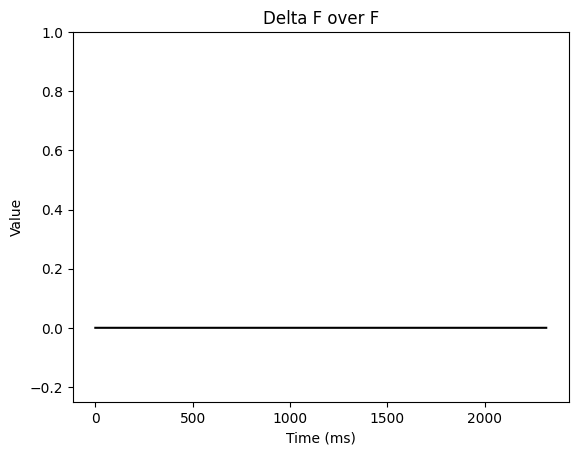

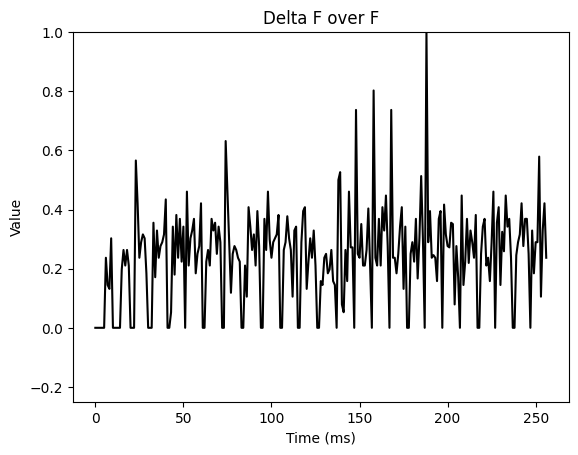

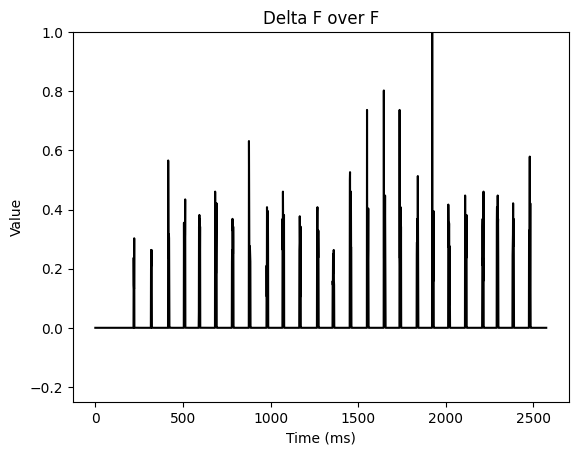

151910130.0
162549749.0
152972025.9545631
0.0
0.0
0.0


1.0

In [59]:
%matplotlib inline
plt.xlabel('Time (ms)')
plt.ylabel('Value')
plt.title('Delta F over F')
plt.plot(baseline_frames_mean, color='black')
plt.ylim(-0.25,1)
plt.show()

plt.xlabel('Time (ms)')
plt.ylabel('Value')
plt.title('Delta F over F')
plt.plot(stim_frames_mean, color='black')
plt.ylim(-0.25,1)
plt.show()

plt.xlabel('Time (ms)')
plt.ylabel('Value')
plt.title('Delta F over F')
plt.plot(deltaFoverF_mean, color='black')
plt.ylim(-0.25,1)
plt.show()

print(np.max(np.mean(baseline_frames,axis=(0))))
print(np.max(np.mean(stimulus_frames,axis=(0))))
print(np.max(np.mean(deltaFoverF_frames,axis=(0))))

print(np.min(np.mean(baseline_frames,axis=(0))))
print(np.min(np.mean(stimulus_frames,axis=(0))))
print(np.min(np.mean(deltaFoverF_frames,axis=(0))))

np.max(normalised_blue_frames)

In [53]:
# '''
# We have to solve the following problem, the widefield computer saves aquisition time in matlab's datetime.datenum function. Which uses
# Gregorian time. However our olfactory stimulus computer saves olfactometer onset as Unix time. Since the above diagrams have shown 
# that the onset of the olfactometer stimulus release is the same as the widefield computer's record of it. We will use the olfactometer
# stimulus frame info which has unix time of onset of stimulus and offset of stimulus. This is how we align and get only frames within the
# window of stimulus on. 
# '''
# # First is a converstion from a matlab datetime to a python datetime in seconds
# unix_blueftimes = [datetime.datetime.fromordinal(int(float(f_time)))+timedelta(days=float(f_time)%1)-timedelta(days=366) for (f_time) in blue_ftimes]
# # Next is a conversion from python datetime into python unix time, with microsecond precision
# unix_blueftimes = [(time.mktime(f_time.timetuple())*1e3 + f_time.microsecond/1e3)/1e3 for f_time in unix_blueftimes]

# # Getting out the start times
# olfactometer_stimulus_block_times = [float(stim_stim['time']) for stim_stim in stim_stim_frame_info]

# plt.figure()
# # The following plot will show the onset and offset of stimulus in green
# for i,x_coord in enumerate(olfactometer_stimulus_block_times[0::2]):
#     if i == 0:
#         plt.axvline(x_coord,color='green',label='Stimulus Onset')
#     else:
#         plt.axvline(x_coord,color='green',label='_nolegend_')
# # The following plot will show the onset and offset of stimulus in green
# for i,x_coord in enumerate(olfactometer_stimulus_block_times[1::2]):
#     if i == 0:
#         plt.axvline(x_coord,color='red',label='Stimulus Offset')
#     else:
#         plt.axvline(x_coord,color='red',label='_nolegend_')
# # Start of olfactometer experiment in black
# plt.axvline(stim_experiment_start_timestamp,color='black',label='Start of Experiment')

# # Time of frames in blue
# plt.plot(unix_blueftimes,np.arange(1,len(unix_blueftimes)+1),label='Frame Acquisition')
# plt.xlabel('Time (s)')
# plt.ylabel('Frame Number')
# # Put a legend below current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#           fancybox=True, shadow=True)
# plt.title("Acquisition over Time")
# plt.show()

In [54]:
# # The following takes the blue frames saves them into jpgs and then converts them to video
# for i,frame in enumerate(tqdm(blue_frames)):
#     plt.imsave(params["path_to_session_data"] + r"\Data\Frame" + str(i) + ".jpg", frame, cmap='gray')
    
# def convert_img_to_video():
#     image_folder = r"C:\Users\evilm\Downloads\12-08-2024\Data"
#     video_name = r"C:\Users\evilm\Downloads\12-08-2024\Data\video_modified.avi"

#     images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
#     frame = cv2.imread(os.path.join(image_folder, images[0]))
#     height, width, layers = frame.shape

#     video = cv2.VideoWriter(video_name, 0, 7, (width,height))

#     for i,image in enumerate(tqdm(images)):
#         video.write(cv2.imread(os.path.join(image_folder, image)))

#     cv2.destroyAllWindows()
#     video.release()
# convert_img_to_video()